In [1]:
using Distributions, LinearAlgebra, Plots, Random, LargeMessageCollider
Random.seed!(1234);

In [2]:
# Generate a synthetic data
A = [1 0 0.1 0; 0 1 0 0.1; 0 0 1 0; 0 0 0 1]
B = [1 0 0 0; 0 1 0 0]
Q = [0.1^3/3 0 0.1^2/2 0; 0 0.1^3/3 0 0.1^2/2; 0.1^2/2 0 0.1 0; 0 0.1^2/2 0 0.1]
R = [0.01 0; 0 0.01]

T = 10

x_real = zeros(4,T)
y_real = zeros(2,T)

x_real[:,1] = rand(MvNormal([0, 0, 10, 0],diagm(0=>ones(4))))
y_real[:,1] = rand(MvNormal((B*x_real[:,1]),R))
for t=2:T
    x_real[:,t] = rand(MvNormal(A*x_real[:,t-1],Q))
    y_real[:,t] = rand(MvNormal((B*x_real[:,t]),R))
end

In [3]:
# Priors
p1 = MvNormal(zeros(4),diagm(0=>4*ones(4)))
pW = Wishart(4, diagm(0=>ones(4)))
pS = Wishart(2, diagm(0=>ones(2)))
;

In [4]:
vmp = VMP() # a VMP instance to enable VMP message passing
# Filtering method
function filter(qW, qS, T)
    forward_estimates = Array{MvNormal}(undef, T)
    measure = B\mvnormal(vmp,y_real[:,1],nothing,qS) # VMP message
    forward_estimates[1] = p1 * measure # Update
    for t=2:T
        predict = transit(vmp,forward_estimates[t-1],A,qW) # Predict message structured VMP
        measure = B\mvnormal(vmp,y_real[:,t],nothing,qS) # VMP message
        forward_estimates[t] = predict * measure
    end
    return forward_estimates
end

# Smoothing method
function smooth(forward_estimates, qW, T)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(vmp,forward_estimates[t],smooth_estimates[t+1],A,qW)
    end
    return smooth_estimates, joint_dists
end
;

In [5]:
# Inference

qW = pW # initial qW
qS = pS # initial qS

n_its = 25
FE = zeros(n_its)

# Variational updates
for i=1:n_its
    # Update q(x_{1:T})
    forward_estimates = filter(qW,qS,T)
    smooth_estimates, joint_dists = smooth(forward_estimates, qW, T)
    
    # Update qW
    qW = pW
    for t=1:T-1
        message = transit(vmp,smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,nothing)
        qW = collide(qW,message,canonical=true)
    end
    qW = convert(Distribution,qW)
    
    # Update qS
    qS = pS
    for t=1:T
        message = mvnormal(vmp,y_real[:,t],B*smooth_estimates[t],nothing)
        qS *= message
    end
    
    # Calculate Free Energy
    F = -entropy(qW) -entropy(qS) - entropy(smooth_estimates[1])
    F += cross_entropy(qW,pW) + cross_entropy(qS,pS) + cross_entropy(smooth_estimates[1], p1)
    for t=1:T-1
        F -= normal_conditional_entropy(smooth_estimates[t], smooth_estimates[t+1], joint_dists[t])
        F += transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,qW)
        F += mvnormal(y_real[:,t],B*smooth_estimates[t],qS)
    end
    F += mvnormal(y_real[:,T],B*smooth_estimates[T],qS)
    FE[i] = F
end

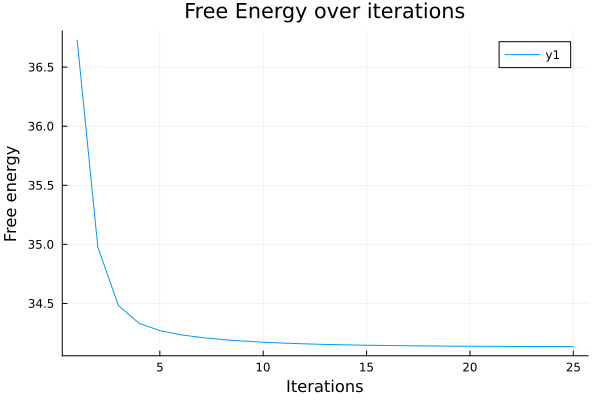

In [6]:
plot(FE, title="Free Energy over iterations", xlabel="Iterations", ylabel="Free energy")

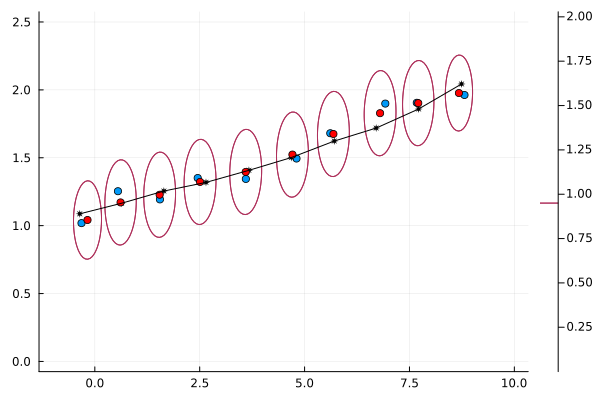

In [7]:
forward_estimates = filter(qW,qS,T)
smooth_estimates, joint_dists = smooth(forward_estimates, qW, T)

X = range(-1, 10, length=200)
Y = range(0, 2.5, length=200)

scatter(y_real[1,:],y_real[2,:], legend=:bottomright)
scatter!(x_real[1,:],x_real[2,:], markershape=:star8, color=:black)

for t=1:T
    scatter!((mean(smooth_estimates[t])[1],mean(smooth_estimates[t])[2]), legend=false, color=:red)
    p = MvNormal(mean(smooth_estimates[t])[1:2],cov(smooth_estimates[t])[1:2,1:2])
    Z = [pdf(p, [x,y]) for y in Y, x in X]
    contour!(X, Y, Z, levels=[0.95,0.95])
end
plot!(x_real[1,:],x_real[2,:], color=:black)